# Speed Dating - Clustering & Random Forest

### Cleaning data 

In [15]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline

In [16]:
import sklearn as sk
import sklearn.tree as tree
import sklearn.preprocessing as pp
import sklearn.metrics as sm
import sklearn.feature_selection as fs
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
data = pd.read_csv('Speed Dating Data.csv',encoding="ISO-8859-1").rename(columns=lambda x: x.strip())
sd_org=data.copy()
wave=[6,12,16,18,19,20,21]
sd = sd_org[~sd_org['wave'].isin(wave)]

In [19]:
# convert income to numeric values
sd['income'] = sd['income'].str.replace(',', '')
sd['income']= pd.to_numeric(sd['income'])

In [20]:
# Drop those colunms for 'half way through' period 
sd= sd.drop(['attr1_s', 'sinc1_s', 'intel1_s', 'fun1_s', 'amb1_s', 'shar1_s',
             'attr3_s', 'sinc3_s', 'intel3_s', 'fun3_s', 'amb3_s'],axis=1)

In [21]:
# Drop those colunms for 'follow-up 2' period 
sd= sd.drop(['attr1_3', 'sinc1_3', 'intel1_3', 'fun1_3', 'amb1_3', 'shar1_3',
             'attr2_3', 'sinc2_3', 'intel2_3', 'fun2_3', 'amb2_3', 'shar2_3',
             'attr3_3', 'sinc3_3', 'intel3_3', 'fun3_3', 'amb3_3',
             'attr4_3', 'sinc4_3', 'intel4_3', 'fun4_3', 'amb4_3', 'shar4_3',
             'attr5_3', 'sinc5_3', 'intel5_3', 'fun5_3', 'amb5_3', 
             'attr7_3', 'sinc7_3', 'intel7_3', 'fun7_3', 'amb7_3', 'shar7_3',],axis=1)

In [22]:
# Drop attr7_2, because it doesn't pair up with the question asked in the correspoding sign up period
sd= sd.drop('attr7_2',axis=1)

### Clustering:<br>
We wanted to cluster the dataset using participants' interests and attributes from the sign up phase. Our initial approach was to check the correlations among these variables and dropped one variable in pairs with high correlations.


In [33]:
# features we want to include in our analysis for sign up phase
features =['gender','match','order','age','field_cd','race','imprace','imprelig','date','go_out',
           'sports','tvsports','exercise','dining','museums','art','hiking','gaming',
           'clubbing','reading','tv','theater','movies','music','shopping','yoga',
           'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1',
           'attr2_1', 'sinc2_1','intel2_1', 'fun2_1', 'amb2_1', 'shar2_1', 'attr3_1',
           'sinc3_1','fun3_1', 'intel3_1', 'amb3_1']

In [34]:
# correlations between features
sd[features].corr().head()

gender     match     order       age  field_cd      race  \
gender    1.000000 -0.000724  0.011169  0.050314 -0.044815 -0.015109   
match    -0.000724  1.000000 -0.049440 -0.041184 -0.025949 -0.006540   
order     0.011169 -0.049440  1.000000  0.047034  0.044093 -0.043188   
age       0.050314 -0.041184  0.047034  1.000000  0.158803 -0.081850   
field_cd -0.044815 -0.025949  0.044093  0.158803  1.000000  0.027053   

           imprace  imprelig      date    go_out    ...      sinc2_1  \
gender   -0.120605 -0.221355 -0.115661  0.029871    ...     0.259003   
match    -0.065969 -0.039233 -0.062664 -0.074592    ...    -0.014450   
order     0.023882  0.047862  0.016869  0.022947    ...     0.025100   
age      -0.123832 -0.070267  0.038015  0.143562    ...     0.008460   
field_cd  0.021084 -0.041499 -0.053468 -0.027092    ...     0.093752   

          intel2_1    fun2_1    amb2_1   shar2_1   attr3_1   sinc3_1  \
gender    0.331696 -0.094029  0.330487 -0.140487 -0.143832 -0.124351   
match     0.018337 -0.015835 -0.011426 -0.027185  0.055283  0.010663   
order     0.018197 -0.043251  0.029522  0.018438 -0.001733  0.015296   
age      -0.058504 -0.036226 -0.034174 -0.045239  0.059097 -0.036548   
field_cd  0.124108 -0.079170  0.107205  0.105485  0.076094  0.033112   

            fun3_1  intel3_1    amb3_1  
gender   -0.141560  0.074327 -0.044746  
match     0.075463  0.019851  0.020332  
order    -0.010031  0.042208  0.000035  
age      -0.083703 -0.032883 -0.066498  
field_cd  0.050488 -0.054842  0.070902  

[5 rows x 43 columns]

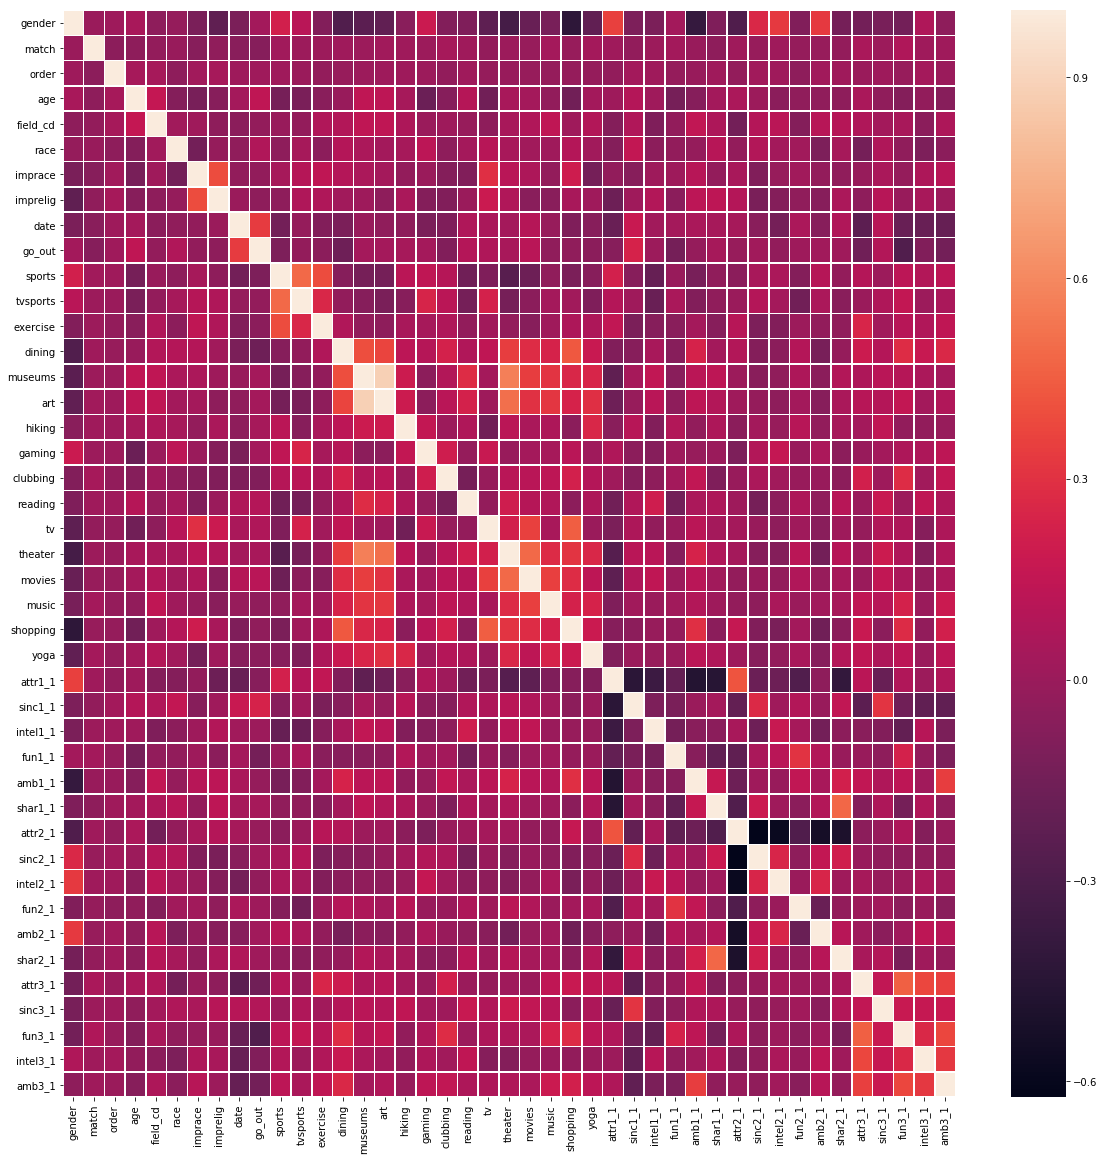

In [35]:
# heatmap of the correlations
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(sd[features].corr(),linewidths=.5, ax=ax)

In [36]:
# drop one feature in the pairs that have high correlations
keep =['gender','match','order','age','field_cd','race','imprace','income','date',
       'exercise','museums','hiking','gaming','clubbing','reading','tv','music','yoga',
       'sinc1_1', 'intel1_1','fun1_1', 'amb1_1', 'shar1_1','intel2_1', 'fun2_1',
       'sinc3_1','fun3_1', 'intel3_1']

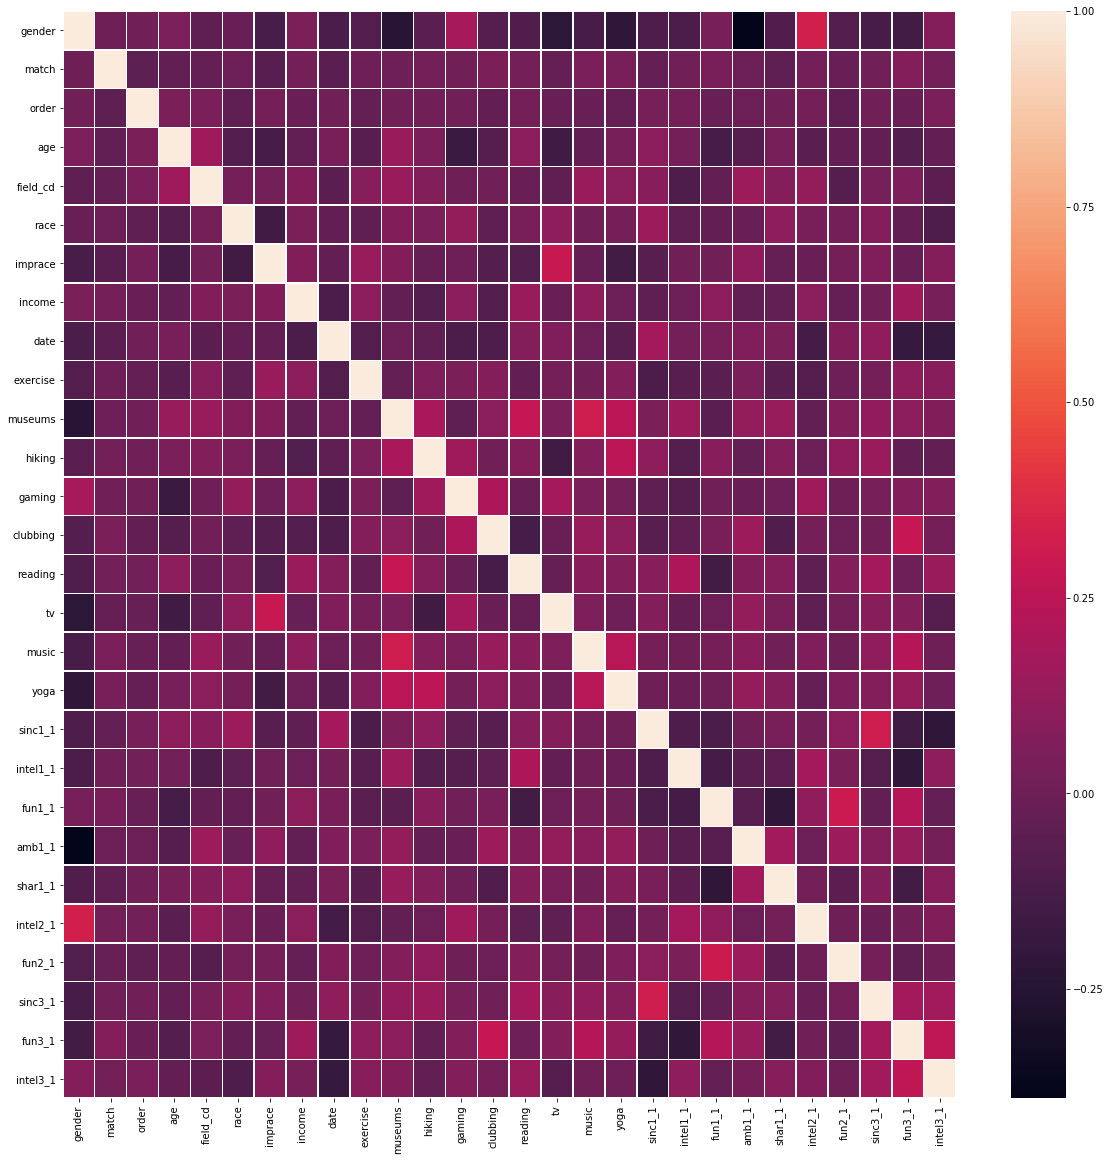

In [37]:
# run the heat map again to make sure the correlations are within a reasonable range 
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(sd[keep].corr(),linewidths=.5, ax=ax)

We decided to drop all NaN values instead of imputing them in some way, because these are all personal preference rankings, it doesn't make sense to impose the mean or median of other people's ranking to a specific participant who was either unwilling or unable to give the ranking at the time.

In [38]:
# drop all NaN values 
temp1 = sd[keep].dropna()

We compared 3 different clustering models using different numbers of clusters and trying to pick the best one.

In [39]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering

bestSil = -1
for k in range(2,6):
    clus = [KMeans(n_clusters=k,n_jobs=-1), Birch(n_clusters=k), 
            AgglomerativeClustering(n_clusters=k)]
    for cl in clus:
        res = cl.fit(temp1)
        sil = metrics.silhouette_score(temp1, res.labels_)
        print (str(cl)[:10] + ' with k =' +str(k) + ": " + str(round(sil,4)))
        if (sil > bestSil):
            bestSil = sil
            bestCl = cl

KMeans(alg with k =2: 0.5542
Birch(bran with k =2: 0.5867
Agglomerat with k =2: 0.5823
KMeans(alg with k =3: 0.5995
Birch(bran with k =3: 0.5761
Agglomerat with k =3: 0.5767
KMeans(alg with k =4: 0.5756
Birch(bran with k =4: 0.561
Agglomerat with k =4: 0.5594
KMeans(alg with k =5: 0.5859
Birch(bran with k =5: 0.5733
Agglomerat with k =5: 0.5749


The results are very close.The number shows that KMeans with cluster of 3 is the best option here.

In [40]:
kmeans = KMeans(n_clusters=3)

In [41]:
cluster = kmeans.fit_predict(temp1)

In [42]:
temp1['cluster']=cluster

In [43]:
temp1.groupby('cluster').mean()

gender     match     order        age  field_cd      race  \
cluster                                                                
0        0.456477  0.176833  8.851953  25.638794  7.661412  2.565456   
1        0.418410  0.202929  9.248954  25.581590  7.228033  2.594142   
2        0.378549  0.164038  9.093849  26.723186  7.128549  2.376972   

          imprace        income      date  exercise    ...       sinc1_1  \
cluster                                                ...                 
0        3.655243  49346.006854  4.878684  6.668266    ...     17.525099   
1        4.600418  75115.211297  4.979079  6.861925    ...     15.732259   
2        3.875394  29461.559937  5.313880  6.267350    ...     17.465450   

          intel1_1     fun1_1     amb1_1    shar1_1   intel2_1     fun2_1  \
cluster                                                                     
0        20.569390  18.026484  11.535175  11.668376  14.460864  17.865031   
1        20.570126  19.795439  11.161548  11.480795  14.327280  18.700711   
2        20.378983  17.521696  11.641774  12.211759  13.370552  19.177571   

          sinc3_1    fun3_1  intel3_1  
cluster                                
0        8.250171  8.118574  8.506511  
1        8.445607  7.991632  8.740586  
2        8.175079  7.253155  8.485016  

[3 rows x 28 columns]

The result was not ideal, it did not give a clearly defined cluster. Also, since our dateset has already been labeled, we decided to move to classification instead of clustering.

# ----------------------------------------------------------------------------------------

### Random Forest: <br>
Here we are trying to use random forest to identify the most important featurs that might determine a match; we first come up with a base model, and then tweak the parameters to get a improved model (determined by roc auc score). With the improved model, we determine the most important features that might determine a match between two people and we use this to plot a decision tree.<br>
**Majority group contain those those who are those who identifies as European/Caucasian, and minority group contain those who identify as African American**

In [44]:
# Drop those columns that won't be used in this analysis 
sd= sd.drop(['id', 'idg', 'wave','round','condtn', 'position', 'positin1','partner','pid','int_corr',
             'age_o','race_o','from','zipcode','career','career_c','satis_2','length',
             'pf_o_att','pf_o_sin','pf_o_int','pf_o_fun','pf_o_amb','pf_o_sha','field',
             'undergra','mn_sat','tuition','exphappy','expnum','numdat_2','samerace',
             'match_es','you_call','them_cal','date_3','numdat_3','num_in_3'],axis=1)

In [52]:
# select interests
interest = ['dec_o','sports','tvsports','exercise',\
          'dining','museums','art','hiking','gaming','clubbing','reading','tv',\
          'theater','movies','music','shopping','yoga','concerts']

In [53]:
# Majority group & interest 
wave_m_i = sd[sd['race']==2].loc[:, interest]

## Description of the dataset
First, we take a look at the activities rated by the majority & minority groups.

| Column | Description |
|--------|-------------|
|`dec_o`|1 = yes, 0 = no|
|`sports`|scale of 1-10|
|`tvsports`| scale of 1-10|
|`exercise`| scale of 1-10|
|`dining`| scale of 1-10|
|`museums`| scale of 1-10|
|`art`| scale of 1-10|
|`hiking`| scale of 1-10|
|`gaming`|scale of 1-10|
|`clubbing`|scale of 1-10|
|`reading`|scale of 1-10|
|`tv`|scale of 1-10|
|`theater`|scale of 1-10|
|`movies`|scale of 1-10|
|`music`|scale of 1-10|
|`shopping`|scale of 1-10|
|`yoga`|scale of 1-10|

### Majority Group Interests:

In [54]:
# drop nan value
wave_m_i=wave_m_i.dropna(axis=0, how='any')

X_m_i, y_m_i = wave_m_i.drop(['dec_o'], axis=1), wave_m_i['dec_o']

In [55]:
# random forest, model with default parameters
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
model = RandomForestRegressor(1000, oob_score=True, n_jobs=-1, random_state=42,min_samples_leaf=10)
model.fit(X_m_i, y_m_i)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [56]:
y_oob = model.oob_prediction_
roc_auc_score(y_m_i, y_oob)

0.70226496132413674

### Below we run some tests to determine best parameter to set and improve our model. 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

auto option
C-stat: 0.701120577118



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

None option
C-stat: 0.701120577118



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

sqrt option
C-stat: 0.701121490433



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

log2 option
C-stat: 0.701121490433



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.9, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

0.9 option
C-stat: 0.701122403749



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.2, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

0.2 option
C-stat: 0.701119968241



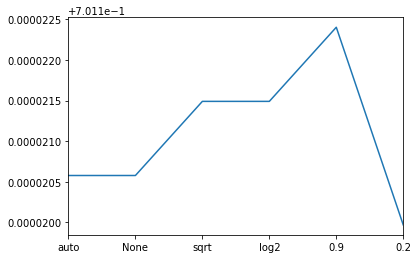

In [65]:
# Max features; # of variables considered at each split point
# best is 0.9
results = []
max_features_options = ['auto',None,'sqrt','log2',0.9,0.2]

for max_features in max_features_options:
    model = RandomForestRegressor(n_estimators = 1000, oob_score=True, 
                                  n_jobs=-1,random_state=42,max_features=max_features)
    model.fit(X_m_i, y_m_i)
    print (max_features,"option")
    roc = roc_auc_score(y_m_i,model.oob_prediction_)
    print ("C-stat:", roc)
    results.append(roc)
    print("")
    
pd.Series(results,max_features_options).plot()

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

200 trees
C-stat: 0.700940958421



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

500 trees
C-stat: 0.70157358156



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

1000 trees
C-stat: 0.701120577118



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

2000 trees
C-stat: 0.701040205362



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2500, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

2500 trees
C-stat: 0.70110626851



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=3000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

3000 trees
C-stat: 0.700826337337



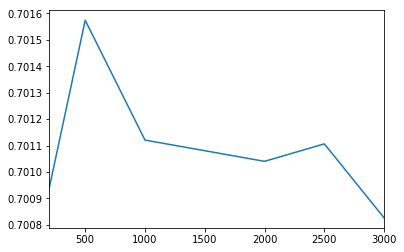

In [45]:
# test n_estimators; how many trees we build
# best result is 500
results = []
n_estimator_options = [200,500,1000,2000,2500,3000]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1,random_state=42)
    model.fit(X_m_i, y_m_i)
    print (trees,"trees")
    roc = roc_auc_score(y_m_i,model.oob_prediction_)
    print ("C-stat:", roc)
    results.append(roc)
    print("")
    
pd.Series(results,n_estimator_options).plot()

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

1 min samples
C-stat: 0.701120577118



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

2 min samples
C-stat: 0.701146911046



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

3 min samples
C-stat: 0.701248593494



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

4 min samples
C-stat: 0.701452110611



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

5 min samples
C-stat: 0.701829309875



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=6, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

6 min samples
C-stat: 0.702069359608



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=7, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

7 min samples
C-stat: 0.702357510619



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

8 min samples
C-stat: 0.702347768588



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=9, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

9 min samples
C-stat: 0.70232554458



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

10 min samples
C-stat: 0.702264961324



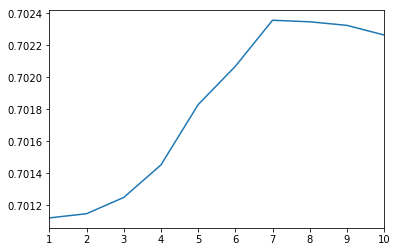

In [46]:
# test min samples
# best result is 7
results = []
min_samples_leaf_options = [1,2,3,4,5,6,7,8,9,10]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(n_estimators = 1000,
                                oob_score=True,
                                n_jobs=-1,
                                random_state=42,
                                max_features="auto",
                                min_samples_leaf=min_samples)
    model.fit(X_m_i, y_m_i)
    print (min_samples,"min samples")
    roc = roc_auc_score(y_m_i,model.oob_prediction_)
    print ("C-stat:", roc)
    results.append(roc)
    print("")
    
pd.Series(results,min_samples_leaf_options).plot()

In [67]:
# Final Model:
model = RandomForestRegressor(n_estimators=500, 
                              oob_score=True, 
                              n_jobs=-1, 
                              random_state=42, 
                              max_features=0.9,
                             min_samples_leaf=7)
model.fit(X_m_i, y_m_i)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.9, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=7, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [68]:
#improved score
y_oob = model.oob_prediction_
roc_auc_score(y_m_i, y_oob)

0.70268630416569255

### We plot out the most important features and use them in our decision tree.

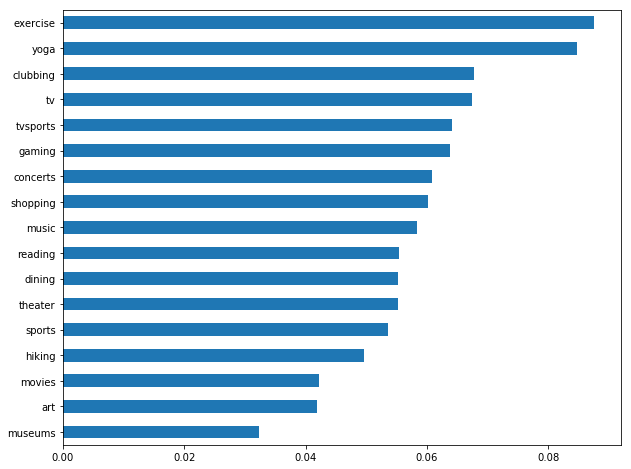

In [69]:
feature_importances = pd.Series(model.feature_importances_, index = X_m_i.columns)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh', figsize=(10,8))

In [57]:
interest_best = ['dec_o','yoga','clubbing','exercise','tv','tvsports']

In [58]:
wave6_m_i = sd[sd['race']==2].loc[:, interest_best]

In [59]:
wave6_m_i=wave6_m_i.dropna(axis=0, how='any')
wave6_m_i.isnull().sum()
len(wave6_m_i[wave6_m_i['dec_o']==1])
len(wave6_m_i[wave6_m_i['dec_o']==0])

dec_o       0
yoga        0
clubbing    0
exercise    0
tv          0
tvsports    0
dtype: int64

1664

1974

In [60]:
X_m_i, y_m_i = wave6_m_i.drop(['dec_o'], axis=1), wave6_m_i['dec_o']

dtc = tree.DecisionTreeClassifier(max_depth=2).fit(X_m_i, y_m_i)
dtc_labels = dtc.predict(X_m_i)

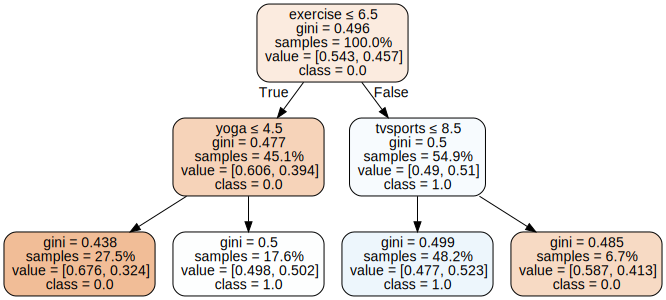

In [61]:
import graphviz
dot_data = sk.tree.export_graphviz(dtc, out_file=None, 
                         feature_names=list(X_m_i.columns),  
                         class_names = ['1.0' if i == 1 else '0.0' for i in dtc.classes_] ,
                         filled=True, rounded=True,  
                         special_characters=True, 
                         proportion=True,
                        )  
graph = graphviz.Source(dot_data)  
graph

As we can see from the tree, although we have matches for those who dislikes exercise but likes yoga, and those who likes exercise but not so much tvsports, the gini score for both classes are close to 0.5, which means the results are inconclusive.


## Minority group Interests

In [62]:
wave_n_i = sd[(sd['race']==1)].loc[:, interest]

In [63]:
wave_n_i=wave_n_i.dropna(axis=0, how='any')
X_n_i, y_n_i = wave_n_i.drop(['dec_o'], axis=1), wave_n_i['dec_o']

In [64]:
# random forest, model with default parameters
model = RandomForestRegressor(100, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X_n_i, y_n_i)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [65]:
y_oob = model.oob_prediction_
roc_auc_score(y_n_i, y_oob)

0.65682940912298715

### Below we run some tests to determine best parameter to set and improve our model. 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

auto option
C-stat: 0.658304997755



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

None option
C-stat: 0.658304997755



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

sqrt option
C-stat: 0.658304997755



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

log2 option
C-stat: 0.658304997755



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.9, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

0.9 option
C-stat: 0.658304997755



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.2, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

0.2 option
C-stat: 0.658304997755



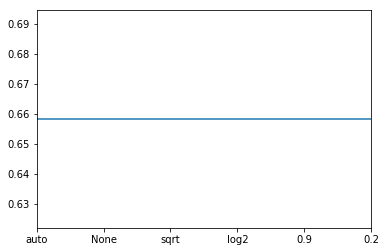

In [135]:
# Max features; # of variables considered at each split point
# best is any, no difference
results = []
max_features_options = ['auto',None,'sqrt','log2',0.9,0.2]

for max_features in max_features_options:
    model = RandomForestRegressor(n_estimators = 1000, oob_score=True, n_jobs=-1,random_state=42,max_features=max_features)
    model.fit(X_n_i, y_n_i)
    print (max_features,"option")
    roc = roc_auc_score(y_n_i,model.oob_prediction_)
    print ("C-stat:", roc)
    results.append(roc)
    print("")

pd.Series(results,max_features_options).plot()

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

30 trees
C-stat: 0.660871238853



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

50 trees
C-stat: 0.658529543851



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

100 trees
C-stat: 0.656829409123



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

200 trees
C-stat: 0.659106948098



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

300 trees
C-stat: 0.660967472894



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

400 trees
C-stat: 0.659588118304



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

500 trees
C-stat: 0.65715018926



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

1000 trees
C-stat: 0.658304997755



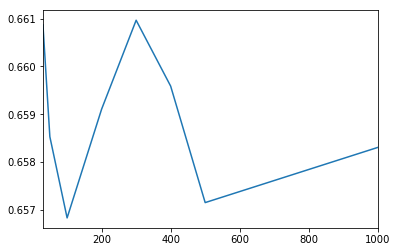

In [114]:
# test n_estimators; how many trees we build
# best result is 300
results = []
n_estimator_options = [30,50,100,200,300,400,500,1000]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1,random_state=42)
    model.fit(X_n_i, y_n_i)
    print (trees,"trees")
    roc = roc_auc_score(y_n_i,model.oob_prediction_)
    print ("C-stat:", roc)
    results.append(roc)
    print("")
    
pd.Series(results,n_estimator_options).plot()

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

5 min samples
C-stat: 0.658657855906



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=6, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

6 min samples
C-stat: 0.65929941618



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=7, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

7 min samples
C-stat: 0.661063706935



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

8 min samples
C-stat: 0.663020465773



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=9, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

9 min samples
C-stat: 0.664335664336



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

10 min samples
C-stat: 0.665618784885



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=11, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

11 min samples
C-stat: 0.665041380638



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=12, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

12 min samples
C-stat: 0.665522550844



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=13, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

13 min samples
C-stat: 0.664592288445



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=14, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

14 min samples
C-stat: 0.663212933855



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=15, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

15 min samples
C-stat: 0.662507217553



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=16, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

16 min samples
C-stat: 0.661320331045



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=17, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

17 min samples
C-stat: 0.659331494194



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=18, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

18 min samples
C-stat: 0.658529543851



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=19, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

19 min samples
C-stat: 0.657855905562



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=20, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

20 min samples
C-stat: 0.659235260153



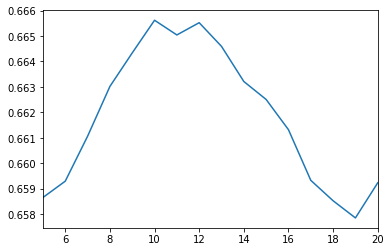

In [115]:
# test min samples
# best result is 10
results = []
min_samples_leaf_options = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(n_estimators = 1000,
                                oob_score=True,
                                n_jobs=-1,
                                random_state=42,
                                max_features="auto",
                                min_samples_leaf=min_samples)
    model.fit(X_n_i, y_n_i)
    print (min_samples,"min samples")
    roc = roc_auc_score(y_n_i,model.oob_prediction_)
    print ("C-stat:", roc)
    results.append(roc)
    print("")
    
pd.Series(results,min_samples_leaf_options).plot()

In [136]:
# final model
model = RandomForestRegressor(n_estimators=300, 
                              oob_score=True, 
                              n_jobs=-1, 
                              random_state=42, 
                              max_features='auto',
                             min_samples_leaf=10)
model.fit(X_n_i, y_n_i)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [137]:
#improved score
y_oob = model.oob_prediction_
roc_auc_score(y_n_i, y_oob)

0.66536216077500476

### We plot out the most important features and use them in our decision tree.

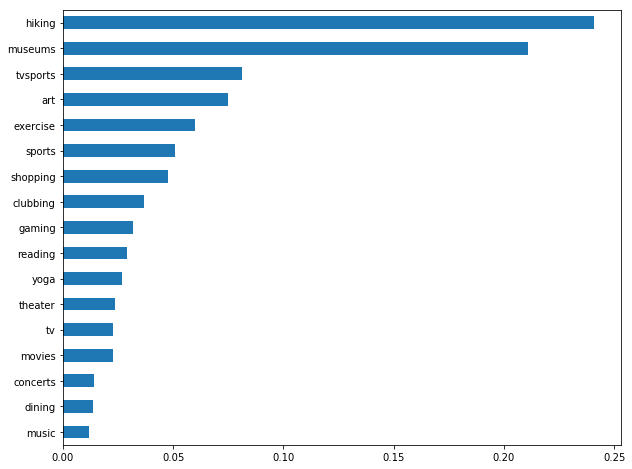

In [138]:
feature_importances = pd.Series(model.feature_importances_, index = X_n_i.columns)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh', figsize=(10,8))

In [148]:
interest_bestr = ['dec_o','hiking','museums','art','tvsports']
                  #'theater','clubbing','movies','reading','gaming','exercise','tv','dining','music','concerts']
wave_n_i = sd[(sd['race']==1)|(sd['race']==5)].loc[:, interest_best]

In [150]:
wave_n_i=wave_n_i.dropna(axis=0, how='any')
wave_n_i.isnull().sum()
len(wave_n_i[wave_n_i['dec_o']==1])
len(wave_n_i[wave_n_i['dec_o']==0])

dec_o       0
yoga        0
clubbing    0
exercise    0
tv          0
tvsports    0
dtype: int64

143

218

In [151]:
X_n_i, y_n_i = wave_n_i.drop(['dec_o'], axis=1), wave_n_i['dec_o']

dtc = tree.DecisionTreeClassifier(max_depth=2).fit(X_n_i, y_n_i)
dtc_labels = dtc.predict(X_n_i)
dtc_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

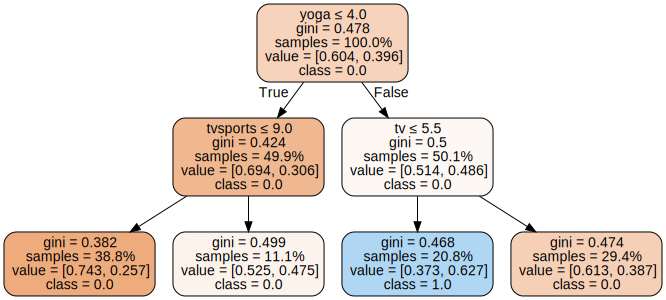

In [152]:
import graphviz
dot_data = sk.tree.export_graphviz(dtc, out_file=None, 
                         feature_names=list(X_n_i.columns),  
                         class_names = ['1.0' if i == 1 else '0.0' for i in dtc.classes_] ,
                         filled=True, rounded=True,  
                         special_characters=True, 
                         proportion=True,
                        )  
graph = graphviz.Source(dot_data)  
graph

For minority group, we only a match for those who likes yoga, but dislikes tv. Again, we observe that the gini score is close to 0.5 but comparatively lower than those in majority group.


## Majority  Group Attributes

## Description of the dataset
Next, we take a look at the attributes of majority & minority groups.


| Column | Description |
|--------|-------------|
|`dec_o`|1 = yes, 0 = no|
|`attr_o`|scale of 1-10, 1=awful, 10=great|
|`sin_o`| scale of 1-10, 1=awful, 10=great|
|`intel_o`| scale of 1-10, 1=awful, 10=great|
|`fun_o`| scale of 1-10, 1=awful, 10=great
|`amb_o`| scale of 1-10, 1=awful, 10=great|
|`shar_o`| scale of 1-10, 1=awful, 10=great|
|`prob_o`| scale of 1-10, 1=awful, 10=great|
|`met_o`|1 = yes, 2 = no|

In [153]:
attributes=['dec_o','gender','attr_o', 'sinc_o', 'intel_o','fun_o', 
            'amb_o', 'shar_o','prob_o','met_o']

In [154]:
wave_m_a = sd[sd['race']==2].loc[:, attributes]
len(wave_m_a)
wave_m_a.isnull().sum()

3654

dec_o        0
gender       0
attr_o      77
sinc_o     116
intel_o    121
fun_o      151
amb_o      344
shar_o     523
prob_o     129
met_o      167
dtype: int64

In [157]:
wave_m_a=wave_m_a.dropna(axis=0, how='any')

In [158]:
X_m_a, y_m_a = wave_m_a.drop(['dec_o'], axis=1), wave_m_a['dec_o']

In [159]:
# random forest, model with default parameters
model= RandomForestRegressor(100, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X_m_a, y_m_a)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [160]:
y_oob = model.oob_prediction_
roc_auc_score(y_m_a,y_oob)

0.81003054389806284

### Below we run some tests to determine best parameter to set and improve our model. 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

auto option
C-stat: 0.816551770672



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

None option
C-stat: 0.816551770672



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

sqrt option
C-stat: 0.828080334063



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

log2 option
C-stat: 0.828080334063



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.9, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

0.9 option
C-stat: 0.818905760575



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.2, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

0.2 option
C-stat: 0.830850097315



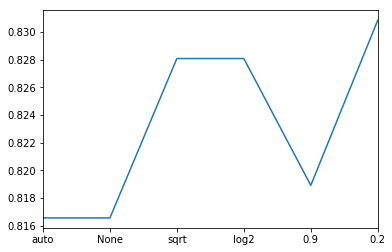

In [164]:
# Max features; # of variables considered at each split point
# best is 0.2
results = []
max_features_options = ['auto',None,'sqrt','log2',0.9,0.2]

for max_features in max_features_options:
    model = RandomForestRegressor(n_estimators = 1000, oob_score=True, n_jobs=-1,random_state=42,max_features=max_features)
    model.fit(X_m_a, y_m_a)
    print (max_features,"option")
    roc = roc_auc_score(y_m_a,model.oob_prediction_)
    print ("C-stat:", roc)
    results.append(roc)
    print("")

pd.Series(results,max_features_options).plot()


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

1000 trees
C-stat: 0.816551770672



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1500, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

1500 trees
C-stat: 0.817046897333



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

2000 trees
C-stat: 0.81763444447



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2500, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

2500 trees
C-stat: 0.817937365052



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=3000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

3000 trees
C-stat: 0.818240998388



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=3250, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

3250 trees
C-stat: 0.818259054831



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=3500, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

3500 trees
C-stat: 0.818361691452



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=4000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

4000 trees
C-stat: 0.818345060518



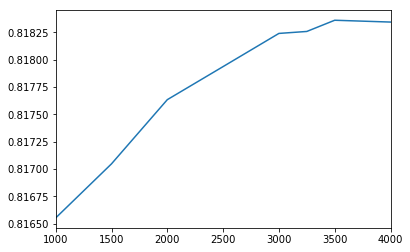

In [169]:
# test n_estimators; how many trees we build
# best result is 4000
results = []
n_estimator_options = [1000,1500,2000,2500,3000,3250,3500,4000]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1,random_state=42)
    model.fit(X_m_a, y_m_a)
    print (trees,"trees")
    roc = roc_auc_score(y_m_a,model.oob_prediction_)
    print ("C-stat:", roc)
    results.append(roc)
    print("")
pd.Series(results,n_estimator_options).plot()

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

10 min samples
C-stat: 0.842189068059



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=11, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

11 min samples
C-stat: 0.842350625703



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=12, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

12 min samples
C-stat: 0.842338746465



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=13, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

13 min samples
C-stat: 0.842243237387



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=14, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

14 min samples
C-stat: 0.842084530761



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=15, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

15 min samples
C-stat: 0.842056020588



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=16, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

16 min samples
C-stat: 0.841886860232



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=17, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

17 min samples
C-stat: 0.84160936122



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=18, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

18 min samples
C-stat: 0.841363698568



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=19, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

19 min samples
C-stat: 0.841126113797



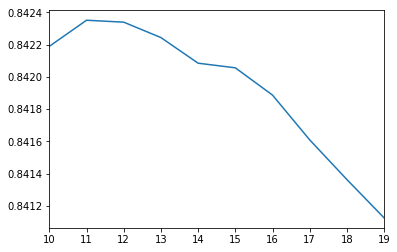

In [171]:
# test min samples
# best result is 11
results = []
min_samples_leaf_options = [10,11,12,13,14,15,16,17,18,19]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(n_estimators = 1000,
                                oob_score=True,
                                n_jobs=-1,
                                random_state=42,
                                max_features="auto",
                                min_samples_leaf=min_samples)
    model.fit(X_m_a, y_m_a)
    print (min_samples,"min samples")
    roc = roc_auc_score(y_m_a,model.oob_prediction_)
    print ("C-stat:", roc)
    results.append(roc)
    print("")
    
pd.Series(results,min_samples_leaf_options).plot()

In [172]:
# final model
model = RandomForestRegressor(n_estimators=4000, 
                              oob_score=True, 
                              n_jobs=-1, 
                              random_state=42, 
                              max_features=0.2,
                             min_samples_leaf=11)
model.fit(X_m_a, y_m_a)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.2, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=11, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=4000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [173]:
#improved score
y_oob = model.oob_prediction_
roc_auc_score(y_m_a, y_oob)

0.84020856141471278

### We plot out the most important features and use them in our decision tree.

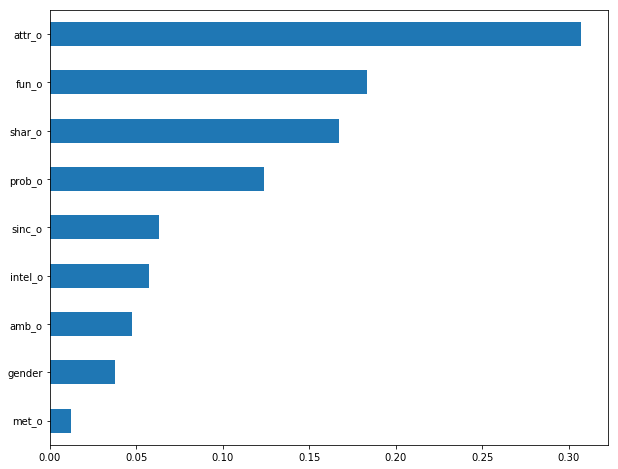

In [174]:
feature_importances = pd.Series(model.feature_importances_, index = X_m_a.columns)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh', figsize=(10,8))

In [179]:
attributes_best = ['dec_o','attr_o','fun_o', 'shar_o','prob_o','sinc_o']
wave_m_a = sd[sd['race']==2].loc[:, attributes_best]
wave_m_a.isnull().sum()

dec_o       0
attr_o     77
fun_o     151
shar_o    523
prob_o    129
sinc_o    116
dtype: int64

In [180]:
wave_m_a=wave_m_a.dropna(axis=0, how='any')

In [181]:
wave_m_a.isnull().sum()
len(wave_m_a[wave_m_a['dec_o']==1])
len(wave_m_a[wave_m_a['dec_o']==0])

X_m_a, y_m_a = wave_m_a.drop(['dec_o'], axis=1), wave_m_a['dec_o']

dec_o     0
attr_o    0
fun_o     0
shar_o    0
prob_o    0
sinc_o    0
dtype: int64

1442

1625

In [182]:
dtc = tree.DecisionTreeClassifier(max_depth=2).fit(X_m_a, y_m_a)
dtc_labels = dtc.predict(X_m_a)

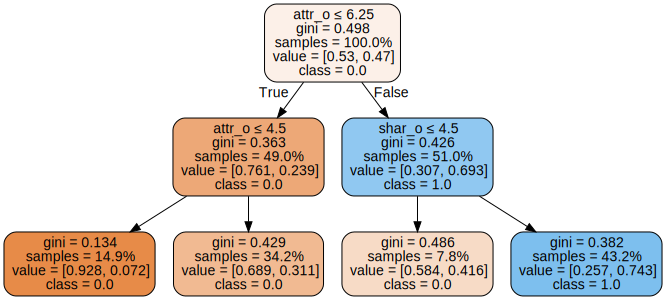

In [183]:


dot_data = sk.tree.export_graphviz(dtc, out_file=None, 
                         feature_names=list(X_m_a.columns),  
                         class_names = ['1.0' if i == 1 else '0.0' for i in dtc.classes_] ,
                         filled=True, rounded=True,  
                         special_characters=True, 
                         proportion=True,
                        )  
graph = graphviz.Source(dot_data)  
graph

For the majority group, attractiveness seems to be the most determinant feature, as it appears in the top and second level of the tree. Those who are attractive and shares alot of interests will get a match. Gini is lower than the decision tree we plotted for interests.

## Minority Group Attributes

In [184]:
wave_n_a = sd[(sd['race']==1)|(sd['race']==5)].loc[:, attributes]

In [185]:
wave_n_a=wave_n_a.dropna(axis=0, how='any')

X_n_a, y_n_a = wave_n_a.drop(['dec_o'], axis=1), wave_n_a['dec_o']

In [186]:
# random forest, model with default parameters
model = RandomForestRegressor(100, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X_n_a, y_n_a)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [187]:
y_oob = model.oob_prediction_
roc_auc_score(y_n_a, y_oob)

0.79198028673835119

### Below we run some tests to determine best parameter to set and improve our model. 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

auto option
C-stat: 0.797535842294



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

None option
C-stat: 0.797535842294



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

sqrt option
C-stat: 0.804256272401



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

log2 option
C-stat: 0.804256272401



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.9, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

0.9 option
C-stat: 0.801500896057



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.2, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

0.2 option
C-stat: 0.798655913978



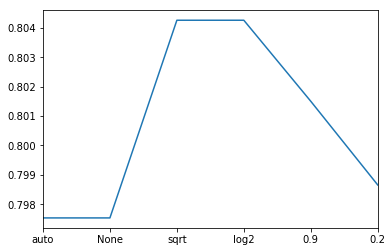

In [189]:
# Max features; # of variables considered at each split point
# best is sqrt or log2
results = []
max_features_options = ['auto',None,'sqrt','log2',0.9,0.2]

for max_features in max_features_options:
    model = RandomForestRegressor(n_estimators = 1000, oob_score=True, n_jobs=-1,random_state=42,max_features=max_features)
    model.fit(X_n_a, y_n_a)
    print (max_features,"option")
    roc = roc_auc_score(y_n_a,model.oob_prediction_)
    print ("C-stat:", roc)
    results.append(roc)
    print("")

pd.Series(results,max_features_options).plot()

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

30 trees
C-stat: 0.795497311828



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

50 trees
C-stat: 0.790927419355



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

100 trees
C-stat: 0.791980286738



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

200 trees
C-stat: 0.796931003584



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

300 trees
C-stat: 0.796617383513



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

400 trees
C-stat: 0.795385304659



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

500 trees
C-stat: 0.797782258065



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

1000 trees
C-stat: 0.797535842294



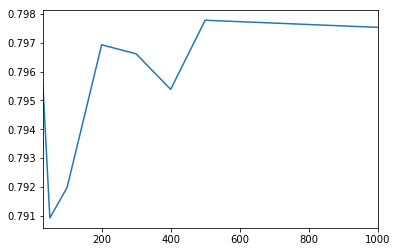

In [198]:
# test n_estimators; how many trees we build
# best result is 500
results = []
n_estimator_options = [30,50,100,200,300,400,500,1000]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1,random_state=42)
    model.fit(X_n_a, y_n_a)
    print (trees,"trees")
    roc = roc_auc_score(y_n_a,model.oob_prediction_)
    print ("C-stat:", roc)
    results.append(roc)
    print("")
    
pd.Series(results,n_estimator_options).plot()

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

1 min samples
C-stat: 0.797535842294



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

2 min samples
C-stat: 0.804077060932



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

3 min samples
C-stat: 0.805017921147



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

4 min samples
C-stat: 0.800313620072



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

5 min samples
C-stat: 0.798431899642



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=6, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

6 min samples
C-stat: 0.798655913978



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=7, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

7 min samples
C-stat: 0.796863799283



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

8 min samples
C-stat: 0.794041218638



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=9, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

9 min samples
C-stat: 0.792114695341



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

10 min samples
C-stat: 0.790098566308



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=11, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

11 min samples
C-stat: 0.788396057348



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=12, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

12 min samples
C-stat: 0.787186379928



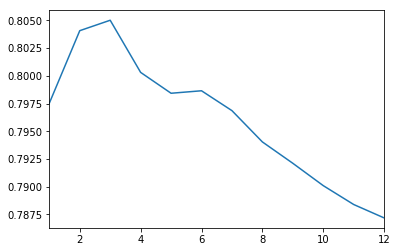

In [190]:
# test min samples
# best result is 3
results = []
min_samples_leaf_options = [1,2,3,4,5,6,7,8,9,10,11,12]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(n_estimators = 1000,
                                oob_score=True,
                                n_jobs=-1,
                                random_state=42,
                                max_features="auto",
                                min_samples_leaf=min_samples)
    model.fit(X_n_a, y_n_a)
    print (min_samples,"min samples")
    roc = roc_auc_score(y_n_a,model.oob_prediction_)
    print ("C-stat:", roc)
    results.append(roc)
    print("")
    
pd.Series(results,min_samples_leaf_options).plot()

In [199]:
# final model
model = RandomForestRegressor(n_estimators=500, 
                              oob_score=True, 
                              n_jobs=-1, 
                              random_state=42, 
                              max_features='log2',
                             min_samples_leaf=3)
model.fit(X_n_a, y_n_a)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [200]:
#improved score
y_oob = model.oob_prediction_
roc_auc_score(y_n_a, y_oob)

0.80501792114695347

### We plot out the most important features and use them in our decision tree.

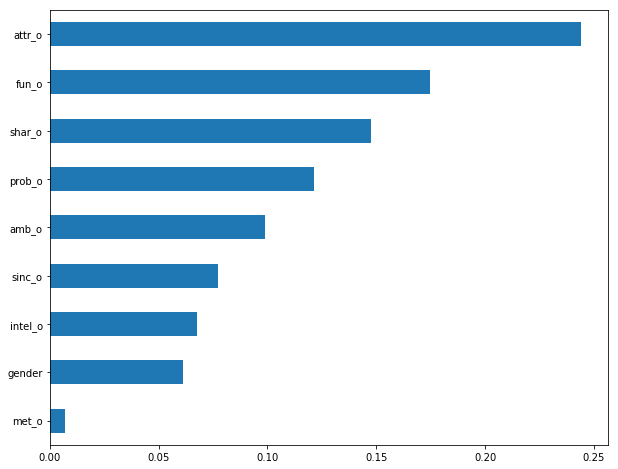

In [201]:
feature_importances = pd.Series(model.feature_importances_, index = X_n_a.columns)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh', figsize=(10,8))

In [202]:
attributes_best = ['dec_o','attr_o','fun_o', 'shar_o','prob_o','amb_o']
wave_n_a = sd[(sd['race']==1)|(sd['race']==5)].loc[:, attributes_best]

In [203]:
wave_n_a=wave_n_a.dropna(axis=0, how='any')
wave_n_a.isnull().sum()
len(wave_n_a[wave_n_a['dec_o']==1])
len(wave_n_a[wave_n_a['dec_o']==0])

dec_o     0
attr_o    0
fun_o     0
shar_o    0
prob_o    0
amb_o     0
dtype: int64

127

185

In [204]:
X_n_a, y_n_a = wave_n_a.drop(['dec_o'], axis=1), wave_n_a['dec_o']

dtc = tree.DecisionTreeClassifier(max_depth=2).fit(X_n_a, y_n_a)
dtc_labels = dtc.predict(X_n_a)

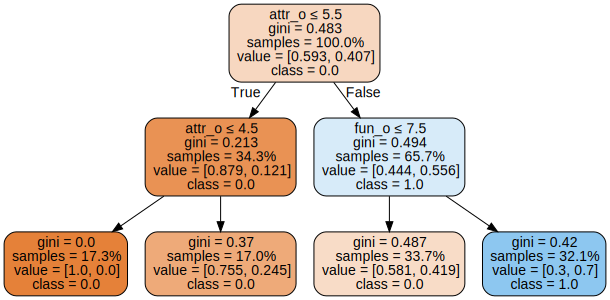

In [205]:
import graphviz
dot_data = sk.tree.export_graphviz(dtc, out_file=None, 
                         feature_names=list(X_n_a.columns),  
                         class_names = ['1.0' if i == 1 else '0.0' for i in dtc.classes_] ,
                         filled=True, rounded=True,  
                         special_characters=True, 
                         proportion=True,
                        )  
graph = graphviz.Source(dot_data)  
graph

For the minority group, attractiveness is still very important, but at a lower standard of 5.5 as compared to the 6.5 for the top level of majority tree. Those who are attractive and fun will get a match.

### References:<br>
Clustering: https://github.com/samorani/Data-Science-Analysis-with-Python<br>
Random Forest: https://www.youtube.com/watch?v=0GrciaGYzV0<br>
